In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as optimize, scipy.stats as stats
import math
import sys

## Define the base params
sigma2theta = 0.2
sigma2eps = 1.0
sigma2x = 0.5
psi = 0.3
W0 = 1.0
c = 0.1
mux = 1.0

#grid of (theta, x) to compute market clearing:
I,J = np.meshgrid(np.arange(-10, 10, 4),np.arange(-10, 10, 4),indexing='ij')
mygrid_mktclear = np.stack((I,J),axis=2)

 
#simulated draws of theta, epsilon, x: to compute expected values
mean = [0, 0, 0]
cov = [[1, 0,0], [0, 1, 0], [0, 0, 1]]
np.random.seed(42)
mygrid = np.random.multivariate_normal(mean,cov, (100000))
mygrid = np.vstack((mygrid,-mygrid))

#The outcome of the economy is defined by realizations of theta, epsilon, x,
#and 1) value of lamb the fraction of actives that are informed
#2) value of m, the fraction of all investors that index


In [2]:
    def get_ABC(lamb, m):
        def check_mkt_clearing(ABC):
            def mkt_clearing(theta_x_tuple):
                theta, x = theta_x_tuple
                x = x - m
                A,B,C = ABC
                kappa = B**2 * sigma2theta / (C**2 * sigma2x + B**2 * sigma2theta)
                sigma2U = (1-kappa) * sigma2theta + sigma2eps
                P = A + B * theta - C * x
                XI = lamb * (theta - P) / (psi * sigma2eps)
                Expecttheta = kappa * (P - A + C * (mux - m)) / B
                XU = (1 - lamb) * (Expecttheta - P) / (psi * sigma2U)
                return XI + XU - x
            return np.sum(np.apply_along_axis(mkt_clearing, 2, mygrid_mktclear).flatten()**2)
        solvemktclear = optimize.minimize(check_mkt_clearing, np.array([0,1,1]), 
                                          bounds=[(None,None),(0.00000001,None),(0.0000001,None)])
        if abs(solvemktclear.fun) < 10**-4:
            return solvemktclear.x
        else:
            sys.exit('Problem solving ABC')
            
    def get_lambda(m):
        def GS80_condition(lamb, m):
            A,B,C = get_ABC(lamb, m)
            kappa = B**2 * sigma2theta / (C**2 * sigma2x + B**2 * sigma2theta)
            sigma2U = (1-kappa) * sigma2theta + sigma2eps
            return (math.exp(-2*psi*c) - sigma2eps / sigma2U)**2

        solveGS80 = optimize.minimize(lambda x: GS80_condition(x, m), [0.5], bounds = [(0,1)])
        if abs(solveGS80.fun) < 10**-5:
            return solveGS80.x[0]
        else:
            sys.exit('Problem solving lambda')


    def exp_util_U(lamb, m):
        A,B,C = get_ABC(lamb, m)
        kappa = B**2 * sigma2theta / (C**2 * sigma2x + B**2 * sigma2theta)
        sigma2U = (1-kappa) * sigma2theta + sigma2eps
        def util_U(thetaepsx):
            theta, eps, x = thetaepsx
            P = A + B * theta - C * x
            Expecttheta = kappa * (P - A + C * mux) / B
            xhat_U = psi**-1 * (Expecttheta - P)/sigma2U
            return - math.exp(-1 * psi * (W0 + xhat_U * (theta + eps - P)))

        util_grid_U = np.apply_along_axis(util_U, 1, mygrid_shifted)
        return np.nanmean(util_grid_U)

    def exp_util_I(lamb, m):
        A,B,C = get_ABC(lamb, m)
        kappa = B**2 * sigma2theta / (C**2 * sigma2x + B**2 * sigma2theta)
        sigma2U = (1-kappa) * sigma2theta + sigma2eps
        def util_I(thetaepsx):
            theta, eps, x = thetaepsx
            P = A + B * theta - C * x
            xhat_I = psi**-1 * (theta - P)/sigma2eps
            return - math.exp(-1 * psi * (W0 - c + xhat_I * (theta + eps - P)))
        util_grid_I = np.apply_along_axis(util_I, 1, mygrid_shifted)
        return np.nanmean(util_grid_I)
    
    def exp_util_Ind(lamb, m):
        A,B,C = get_ABC(lamb, m)
        kappa = B**2 * sigma2theta / (C**2 * sigma2x + B**2 * sigma2theta)
        sigma2U = (1-kappa) * sigma2theta + sigma2eps
        sigma2Ind = (1-B)**2 * sigma2theta + sigma2eps + C**2 * sigma2x
        def util_Ind(thetaepsx):
            theta, eps, x = thetaepsx
            yhat_Ind = 1/psi * (C * mux - A) / sigma2Ind
            return -math.exp(-1 * psi * (W0 + cInd + yhat_Ind * (theta + eps - (A + B * theta - C * x))))

        util_grid_Ind = np.apply_along_axis(util_Ind, 1, mygrid_shifted)
        return np.nanmean(util_grid_Ind)

In [3]:
print(get_ABC(0.5, 0.7))
print(get_ABC(0.5, 0.5))
print(get_ABC(0.5, 0))


[0.04522607 0.77386934 0.4643216 ]
[0.07537688 0.77386935 0.4643216 ]
[0.15075378 0.77386935 0.4643216 ]


In [4]:
print(get_lambda(0.7))
print(get_lambda(0.5))
print(get_lambda(0.0))

0.7090116330303906
0.7086661560240443
0.7090116344307968


In [5]:
#as we verified above, m does not change the equilibrium lambda, B, or C:
lamb = get_lambda(0.5)
A,B,C = get_ABC(lamb, 0.5)
kappa = B**2 * sigma2theta / (C**2 * sigma2x + B**2 * sigma2theta)
sigma2U = (1-kappa) * sigma2theta + sigma2eps
sigma2Ind = (1-B)**2 * sigma2theta + sigma2eps + C**2 * sigma2x

def active_vs_index(m):
    global mygrid_shifted
    mygrid_shifted = mygrid.copy()
    mygrid_shifted[:,2] = mygrid[:,2] + (mux - m)
    util_actives = (exp_util_U(lamb, m) + exp_util_I(lamb, m))/2.0
    return (exp_util_Ind(lamb, m) - util_actives)**2

In [6]:
cInd = 0.043
solve_for_m = optimize.minimize(active_vs_index, [0.5], bounds = [(0,1)])
print(solve_for_m)
#check: interior solution for different values of cInd
#cInd = cA - cI
#higher value of cInd means more preference to be an indexer (higher m)


      fun: 1.3158254578226715e-06
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.08439761e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([0.])


In [9]:
from tqdm import tqdm

#vary the cost advantage of indexing, solve the resulting equilibria:
model_graphs = []
cInd_list = [0.00, 0.043, 0.05, 0.055, 0.061, 0.07, 0.08, 0.10, 0.12, 0.15, 0.17, 0.20, 0.218]
for c_in in tqdm(cInd_list):
    global cInd
    cInd = c_in
    solve_for_m = optimize.minimize(active_vs_index, [0.5], bounds = [(0,1)])
    m = solve_for_m.x[0]
    lamb = get_lambda(m)
    A,B,C = get_ABC(lamb, m)
    kappa = B**2 * sigma2theta / (C**2 * sigma2x + B**2 * sigma2theta)
    sigma2U = (1-kappa) * sigma2theta + sigma2eps
    sigma2Ind = (1-B)**2 * sigma2theta + sigma2eps + C**2 * sigma2x
    c_spent = (1-m) * lamb * c
    rho_theta = math.sqrt(1-sigma2eps / sigma2theta*(math.exp(2*psi*c) - 1))
    var_P = B**2 * sigma2theta + C**2 * sigma2x
    std_P = var_P**0.5
    model_graphs.append({'cInd':cInd,'lamb':lamb,'m':m,'c_spent':c_spent,'rho_theta':rho_theta,'std_P':std_P})
    print(cInd)
    sys.stdout.flush()

  0%|                                                    | 0/13 [00:00<?, ?it/s]

0.0


  8%|███▍                                        | 1/13 [00:16<03:14, 16.21s/it]

0.043


 15%|██████▊                                     | 2/13 [00:41<03:58, 21.70s/it]

0.05


 23%|██████████▏                                 | 3/13 [01:03<03:39, 21.95s/it]

0.055


 31%|█████████████▌                              | 4/13 [01:26<03:19, 22.15s/it]

0.061


 38%|████████████████▉                           | 5/13 [01:45<02:48, 21.07s/it]

0.07


 46%|████████████████████▎                       | 6/13 [02:01<02:15, 19.39s/it]

0.08


 54%|███████████████████████▋                    | 7/13 [02:17<01:50, 18.35s/it]

0.1


 62%|███████████████████████████                 | 8/13 [02:27<01:18, 15.68s/it]

0.12


 69%|██████████████████████████████▍             | 9/13 [02:47<01:07, 16.81s/it]

0.15


 77%|█████████████████████████████████          | 10/13 [03:15<01:01, 20.40s/it]

0.17


 85%|████████████████████████████████████▍      | 11/13 [03:47<00:48, 24.04s/it]

0.2


 92%|███████████████████████████████████████▋   | 12/13 [04:16<00:25, 25.42s/it]

0.218


100%|███████████████████████████████████████████| 13/13 [04:44<00:00, 21.91s/it]


In [10]:
graphs_df = pd.DataFrame.from_records(model_graphs)
graphs_df

cInd      lamb         m   c_spent  rho_theta     std_P
0   0.000  0.709012  0.000000  0.070901   0.831154  0.491690
1   0.043  0.709012  0.000000  0.070901   0.831154  0.491690
2   0.050  0.709012  0.102459  0.063637   0.831154  0.491690
3   0.055  0.708770  0.167632  0.058996   0.831154  0.491682
4   0.061  0.708694  0.243452  0.053616   0.831154  0.491679
5   0.070  0.708705  0.329459  0.047522   0.831154  0.491680
6   0.080  0.709008  0.402153  0.042388   0.831154  0.491690
7   0.100  0.709022  0.529533  0.033357   0.831154  0.491691
8   0.120  0.709012  0.628905  0.026311   0.831154  0.491690
9   0.150  0.709012  0.759614  0.017044   0.831154  0.491690
10  0.170  0.709012  0.836143  0.011618   0.831154  0.491690
11  0.200  0.709012  0.939586  0.004283   0.831154  0.491690
12  0.218  0.709012  0.996983  0.000214   0.831154  0.491690

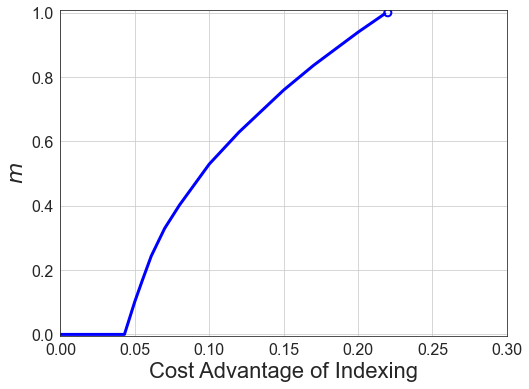

In [11]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn 
seaborn.set_style("white")


fig = plt.figure(figsize=(8, 6))
plot(graphs_df.cInd, graphs_df.m, color="blue", linewidth = 3)
plt.scatter(0.22, 1.0, s=50, facecolors='none', edgecolors='b', linewidth=2)
axes = plt.gca()
axes.set_xlim([0,0.3])
axes.set_ylim([-0.004,1.01])
xlabel('Cost Advantage of Indexing', fontsize = 22)
ylabel('$m$', fontsize = 22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
grid(True)
#plt.savefig('m.pdf', bbox_inches='tight')
plt.show()




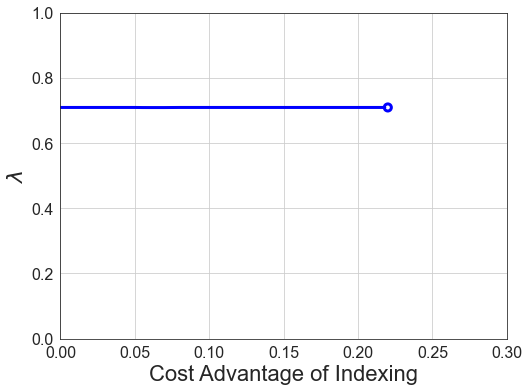

In [12]:
fig = plt.figure(figsize=(8, 6))
plot(graphs_df.cInd, graphs_df.lamb, color="blue", linewidth = 3)
plt.scatter(0.22, 0.709, s=50, facecolors='none', edgecolors='b', linewidth=3)
axes = plt.gca()
axes.set_xlim([0,0.30])
axes.set_ylim([0.0,1.0])
xlabel('Cost Advantage of Indexing', fontsize = 22)
ylabel('$\lambda$', fontsize = 22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
grid(True)
#plt.savefig('lamb.pdf', bbox_inches='tight')
plt.show()


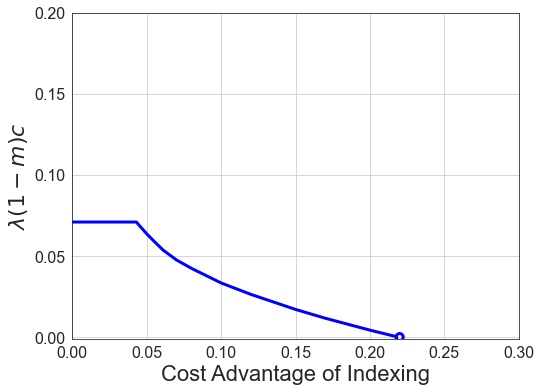

In [13]:
fig = plt.figure(figsize=(8, 6))
plot(graphs_df.cInd, graphs_df.c_spent, color="blue", linewidth = 3)
plt.scatter(0.22, 0.00, s=50, facecolors='none', edgecolors='b', linewidth=3)
axes = plt.gca()
axes.set_xlim([0,0.3])
axes.set_ylim([-0.001,0.1])
xlabel('Cost Advantage of Indexing', fontsize = 22)
ylabel('$\lambda (1 - m) c $', fontsize = 22)
plt.xticks(fontsize=16)
plt.yticks([0.00, 0.05, 0.10, 0.15,0.20],fontsize=16)
grid(True)
#plt.savefig('infoprod.pdf', bbox_inches='tight')
plt.show()


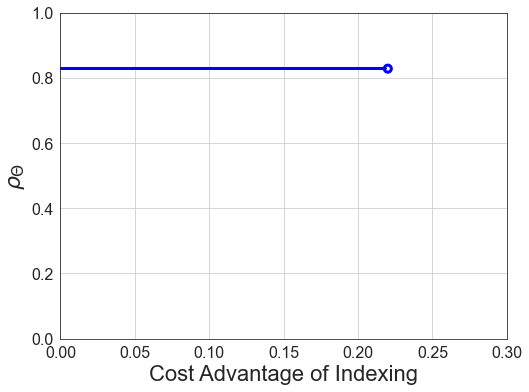

In [14]:
fig = plt.figure(figsize=(8, 6))
plot(graphs_df.cInd, graphs_df.rho_theta, color="blue", linewidth = 3)
plt.scatter(0.22, 0.828, s=50, facecolors='none', edgecolors='b', linewidth=3)
axes = plt.gca()
axes.set_xlim([0,0.3])
axes.set_ylim([0.0,1.0])
xlabel('Cost Advantage of Indexing', fontsize = 22)
ylabel(r'$\rho_\Theta $', fontsize = 22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
grid(True)
#plt.savefig('rho_theta.pdf', bbox_inches='tight')
plt.show()
